In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [2]:
# --- 1. Setup and Configuration ---

# Define key parameters for the project
IMAGE_SIZE = (224, 224) # The input size MobileNetV2 was trained on
BATCH_SIZE = 32
EPOCHS = 10 # Increase epochs for better performance
LEARNING_RATE = 0.001

In [9]:
# --- 2. Download and Prepare the Dataset (Modernized) ---

# Download the flowers dataset if it's not already cached
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)
data_dir = pathlib.Path('datasets/flower_photos')

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Found {image_count} images in dataset.")

# Use the modern Keras utility to create datasets directly from the image folders.
# This automatically handles creating labels from the folder names.
print("\nCreating training and validation datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # Use 20% of the data for validation
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

# Get the class names from the dataset
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 453 images in dataset.

Creating training and validation datasets...
Found 453 files belonging to 3 classes.
Using 363 files for training.
Found 453 files belonging to 3 classes.
Using 90 files for validation.
Found 3 classes: ['roses', 'sunflowers', 'tulips']


In [10]:
# --- 3. Build the Model with Transfer Learning (Modernized) ---

print("\nBuilding the model with MobileNetV2 base...")

# Define the input shape
input_shape = IMAGE_SIZE + (3,)

# Load the MobileNetV2 model pre-trained on ImageNet
# include_top=False removes the final classification layer.
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# Freeze the convolutional base to prevent its weights from being updated during training.
base_model.trainable = False

# Create a data augmentation layer to be part of the model.
# This helps prevent overfitting by creating modified versions of images during training.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

# Create the new model by stacking layers on top of the base model.
# The Functional API is more flexible for transfer learning.
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Use the specific preprocessing for MobileNetV2
x = base_model(x, training=False) # Set training=False for the frozen base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Add a dropout layer for regularization
outputs = layers.Dense(num_classes, activation='softmax')(x) # New classification head

model = tf.keras.Model(inputs, outputs)


Building the model with MobileNetV2 base...


In [11]:
# --- 4. Compile the Model ---

print("\nCompiling the model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', # Use for integer labels
    metrics=['accuracy']
)

# Display the final model architecture
model.summary()


Compiling the model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# --- 5. Train the Model ---

print("\nStarting model training...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("\nTraining finished.")


Starting model training...
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - accuracy: 0.3786 - loss: 1.2879 - val_accuracy: 0.4889 - val_loss: 0.9459
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 649ms/step - accuracy: 0.6521 - loss: 0.8018 - val_accuracy: 0.6889 - val_loss: 0.7463
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.7921 - loss: 0.5624 - val_accuracy: 0.7444 - val_loss: 0.6217
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.8320 - loss: 0.4483 - val_accuracy: 0.7778 - val_loss: 0.5620
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 676ms/step - accuracy: 0.8265 - loss: 0.4061 - val_accuracy: 0.7889 - val_loss: 0.5319
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 546ms/step - accuracy: 0.8132 - loss: 0.4421 - val_accuracy: 0.8000 - val_loss: 0.5081
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.8701 - loss: 0.3539 - val_accuracy: 0.7889 - val_loss: 0.4916
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.8652 - lo


Plotting training history...


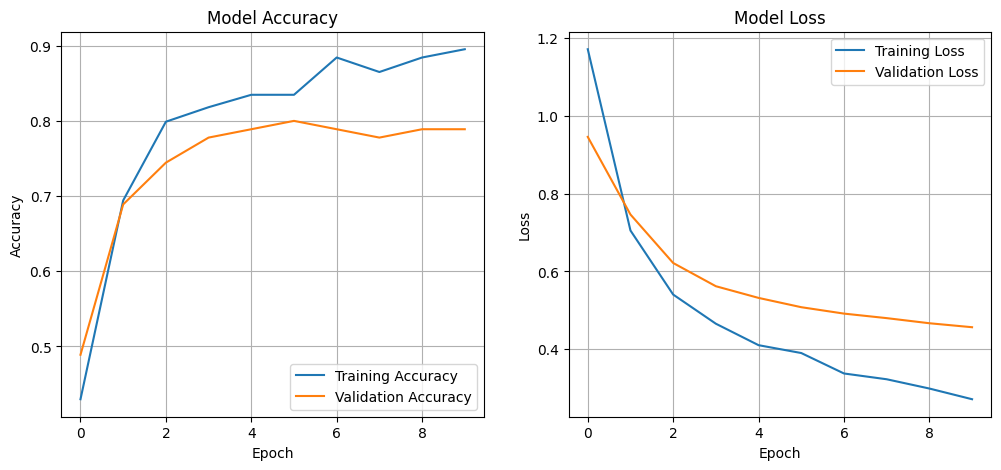

In [14]:
# --- 6. Evaluate and Plot Results ---

print("\nPlotting training history...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


--- Making a prediction on a new image ---
117948/117948 ━━━━━━━━━━━━━━━━━━━━ 1s 4us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


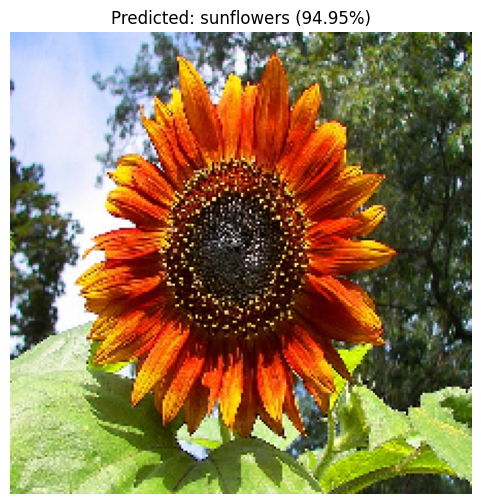

In [15]:
# --- 7. Make a Prediction on a New Image ---

print("\n--- Making a prediction on a new image ---")
# Download a new image that the model has not seen before
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower.jpg', origin=sunflower_url)

# Load and prepare the image for prediction
img = tf.keras.utils.load_img(sunflower_path, target_size=IMAGE_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_batch = tf.expand_dims(img_array, 0) # Create a batch

# Get the model's prediction
predictions = model.predict(img_batch)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions[0])

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({confidence:.2%})")
plt.axis("off")
plt.show()